In [34]:
import numpy as np
import matplotlib.pyplot as plt


class Properties:
    
    def __init__(self, AT=0, BT=0, CT=0, CR=0):
        self.AT = AT
        self.BT = BT
        self.CT = CT
        self.CR = CR
        
    def unpack(self):
        return self.AT, self.BT, self.CT, self.CR
    
    
class Conditions:
    
    def __init__(self, initial_spin, initial_omega, target_omega):
        self.initial_spin = initial_spin
        self.initial_omega = initial_omega
        self.target_omega = target_omega
        
    def unpack(self):
        return self.initial_spin, self.initial_omega, self.target_omega
    

def plot_simulation(t, omega, spin):
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 5))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.25)

    ax0.plot(t, spin[:, 0], label=r'$\dot{\lambda}_1$')
    ax0.plot(t, spin[:, 1], label=r'$\dot{\lambda}_2$')
    ax0.plot(t, spin[:, 2], label=r'$\dot{\lambda}_3$')

    ax0.legend(loc = 'lower right')
    ax0.set_xlabel('Time t (s)', fontsize=12)
    ax0.set_ylabel(r'$\mathbf{\dot{\lambda}}$ (rad/s)', fontsize=12)

    ax1.plot(t, omega[:, 0], label=r'$\Omega_1$')
    ax1.plot(t, omega[:, 1], label=r'$\Omega_2$')
    ax1.plot(t, omega[:, 2], label=r'$\Omega_3$')
    ax1.legend(loc = 'lower right')
    ax1.set_xlabel('Time t (s)', fontsize=12)
    ax1.set_ylabel(r'$\mathbf{\Omega}$ (rad/s)', fontsize=12, labelpad=-4)

    plt.show()

In [82]:
def get_h_dot(properties, t, omega, spin, spin_acc):
    AT, BT, CT, CR = properties.unpack()
    
    hdot = np.zeros(omega.shape)
    
    omega_dot = np.gradient(omega, 2, axis=0)
    
    for i in range(omega.shape[0]):
        hdot[i,0] = AT*omega_dot[i,0] + CR*spin_acc[i,0] + (CT-BT)*omega[i,1]*omega[i,2] \
                               + CR*(omega[i,1]*spin[i,2] - omega[i,2]*spin[i,1])
        hdot[i,1] = BT*omega_dot[i,1] + CR*spin_acc[i,1] + (AT-CT)*omega[i,0]*omega[i,2] \
                               + CR*(omega[i,2]*spin[i,0] - omega[i,0]*spin[i,2])
        hdot[i,2] = CT*omega_dot[i,2] + CR*spin_acc[i,2] + (BT-AT)*omega[i,0]*omega[i,1] \
                               + CR*(omega[i,0]*spin[i,1] - omega[i,1]*spin[i,0])
        
    return hdot
                        
def plot_h_dot(properties, t, omega, spin, spin_acc):
    hdot = get_h_dot(properties, t, omega, spin, spin_acc)
    plt.plot(t, hdot[:,0])
    plt.plot(t, hdot[:,1])
    plt.plot(t, hdot[:,2])
    

In [79]:
  
def simulate(properties, conditions, T, N, kp=10):
    
    AT, BT, CT, CR = properties.unpack()
    initial_spin, initial_omega, target_omega = conditions.unpack()
    
    def f(omega, spin, spin_acc):

        omega_1 = -(1/AT)*(CR*spin_acc[0] + (CT-BT)*omega[1]*omega[2]
                           + CR*(omega[1]*spin[2] - omega[2]*spin[1]))
        omega_2 = -(1/BT)*(CR*spin_acc[1] + (AT-CT)*omega[0]*omega[2]
                           + CR*(omega[2]*spin[0] - omega[0]*spin[2]))
        omega_3 = -(1/CT)*(CR*spin_acc[2] + (BT-AT)*omega[0]*omega[1]
                           + CR*(omega[0]*spin[1] - omega[1]*spin[0]))

        return np.array([omega_1, omega_2, omega_3])
    
    omega = np.zeros((N, 3))
    omega[0] = initial_omega
    
    spin = np.zeros((N, 3))
    spin[0] = initial_spin
    spin_acc = np.zeros((N, 3))
    
    t = np.linspace(0, T, N)
    dt = T/(N-1)

    for n in range(N-1):
        
        spin_acc[n+1] = -kp*(target_omega - omega[n])
        
        spin[n+1] = spin[n] + 0.5*(spin_acc[n] + spin_acc[n+1])*dt
        
        k1 = f(omega[n], spin[n], spin_acc[n])
        k2 = f(omega[n] + k1*dt/2, (spin[n]+spin[n+1])/2, (spin_acc[n]+spin_acc[n+1])/2)
        k3 = f(omega[n] + k2*dt/2, (spin[n]+spin[n+1])/2, (spin_acc[n]+spin_acc[n+1])/2)
        k4 = f(omega[n] + k3*dt, spin[n+1], spin_acc[n+1])

        omega[n+1] = omega[n] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*dt

    return t, omega, spin, spin_acc

# Rotating about one axis with no initial spin or rotation

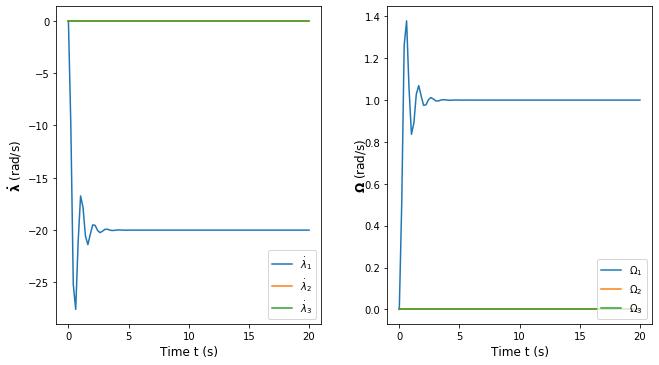

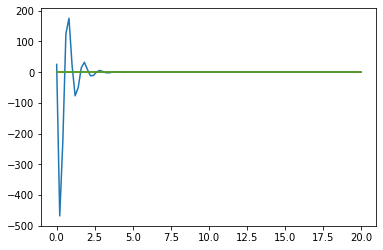

In [83]:
properties = Properties(100, 150, 200, 5)

conditions = Conditions(np.array([0, 0, 0]),
                        np.array([0, 0, 0]),
                        np.array([1, 0, 0]))
t, omega, spin, spin_acc = simulate(properties, conditions, 20, 100, kp=100)

plot_simulation(t, omega, spin)
plot_h_dot(properties, t, omega, spin, spin_acc)

# Rotating about one axis with non-zero initial spin but no initial rotation

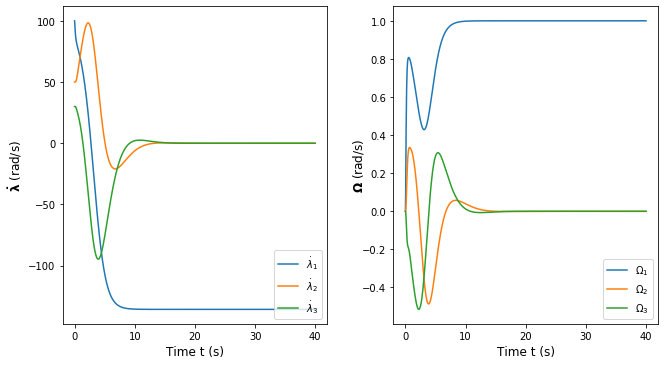

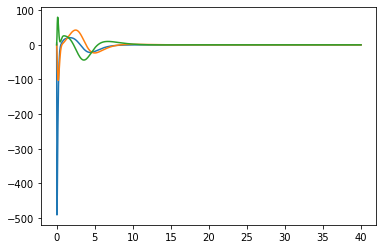

In [91]:
properties = Properties(100, 100, 100, 5)

conditions = Conditions(np.array([100, 50, 30]),
                        np.array([0, 0, 0]),
                        np.array([1, 0, 0]))
t, omega, spin, spin_acc = simulate(properties, conditions, 40, 1000, kp=100)

plot_simulation(t, omega, spin)
plot_h_dot(properties, t, omega, spin, spin_acc)